# Single Input Multiple Output Anchor-Free Object Detection

Code is based off of ART-Net (https://github.com/kamruleee51/ART-Net).

Initially 1324 train and 308 val images before cleaning negative samples and those with missing bounding boxes.

In [2]:
print(len(train_dataset), len(val_dataset))

662 154


In [3]:
import certifi

os.environ["SSL_CERT_FILE"] = certifi.where()

[[(array([ 0.10101846, -0.03700255,  0.00895285, -0.21672349], dtype=float32), array([0.6047118], dtype=float32))], [(array([ 0.10124177, -0.03710567,  0.0091766 , -0.2169755 ], dtype=float32), array([0.6048366], dtype=float32))], [(array([ 0.10054091, -0.03662965,  0.00880097, -0.21574463], dtype=float32), array([0.6045363], dtype=float32))], [(array([ 0.10054091, -0.03662965,  0.00880097, -0.21574463], dtype=float32), array([0.6045363], dtype=float32))], [(array([ 0.09971479, -0.0362925 ,  0.0079059 , -0.2138909 ], dtype=float32), array([0.6042593], dtype=float32))], [(array([ 0.10033342, -0.03680342,  0.00822789, -0.21524969], dtype=float32), array([0.6041018], dtype=float32))], [(array([ 0.10018344, -0.03653961,  0.00812593, -0.2145511 ], dtype=float32), array([0.60403603], dtype=float32))], [(array([ 0.10005435, -0.03652795,  0.00815201, -0.21491632], dtype=float32), array([0.6035945], dtype=float32))], [(array([ 0.10005435, -0.03652795,  0.00815201, -0.21491632], dtype=float32), 

2024-07-31 21:02:02.601 Python[92369:2807762] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


: 

Using device: cuda
[[(array([ 0.04939602,  0.00257626,  0.0490801 , -0.08424167], dtype=float32), array([0.5197669], dtype=float32))], [(array([ 0.04929385,  0.00245655,  0.04903817, -0.0838613 ], dtype=float32), array([0.5199694], dtype=float32))], [(array([ 0.04929385,  0.00245655,  0.04903817, -0.0838613 ], dtype=float32), array([0.5199694], dtype=float32))], [(array([ 0.04929385,  0.00245655,  0.04903817, -0.0838613 ], dtype=float32), array([0.5199694], dtype=float32))], [(array([ 0.04929385,  0.00245655,  0.04903817, -0.0838613 ], dtype=float32), array([0.5199694], dtype=float32))], [(array([ 0.0492024 ,  0.00281262,  0.04920099, -0.08405028], dtype=float32), array([0.51977724], dtype=float32))], [(array([ 0.0492024 ,  0.00281262,  0.04920099, -0.08405028], dtype=float32), array([0.51977724], dtype=float32))], [(array([ 0.04931024,  0.00244662,  0.04905386, -0.0840586 ], dtype=float32), array([0.5199107], dtype=float32))], [(array([ 0.04931024,  0.00244662,  0.04905386, -0.0840586

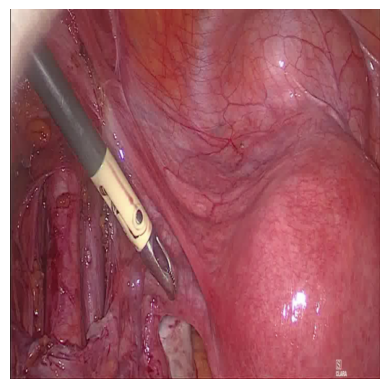

In [3]:
# python "SIMO Tracking.py" > chkpts/SIMO/results.txt

from math import e
import os
import cv2
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional
import torch.optim as optim
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_recall_curve, average_precision_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define the ToolDataset class
class ToolDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, max_bboxes=4):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.max_bboxes = max_bboxes
        self.image_files = [
            f
            for f in os.listdir(image_dir)
            if os.path.isfile(os.path.join(image_dir, f))
            and not "Neg" in f
            and os.path.exists(os.path.join(label_dir, f.replace(".png", ".txt")))
            and os.path.getsize(os.path.join(label_dir, f.replace(".png", ".txt"))) > 1
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".png", ".txt"))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))  # Resize images to 512x512
        image = image / 255.0

        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            labels = np.loadtxt(label_path, delimiter=" ")
            if labels.ndim == 1:
                labels = labels[np.newaxis, :]
        else:
            labels = np.zeros((0, 5))  # No bounding boxes

        # Pad labels to fixed size
        if len(labels) > self.max_bboxes:
            labels = labels[: self.max_bboxes]
        else:
            padding = np.zeros((self.max_bboxes - len(labels), 5))
            labels = np.vstack((labels, padding))

        labels = torch.tensor(labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels


# Define the SIMOModel class
class SIMOModel(nn.Module):
    def __init__(self, n_classes=4):
        super(SIMOModel, self).__init__()
        self.vgg_base = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features

        # Feature representation generator (FRG)
        self.frg = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder for tool bounding box regression
        self.tool_decoder = nn.Sequential(
            nn.Conv2d(
                1024, 512, kernel_size=3, padding=1
            ),  # 1024 channels due to concatenation of VGG and FRG
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, n_classes, kernel_size=1
            ),  # 4 outputs for bounding box coordinates
            nn.AdaptiveAvgPool2d((1, 1)),  # Pooling to get a 1x1 output
            nn.Flatten(),  # Flatten to shape [batch_size, 4]
        )

        # Decoder for tooltip bounding box regression
        self.tooltip_decoder = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, n_classes, kernel_size=1
            ),  # 4 outputs for bounding box coordinates
            nn.AdaptiveAvgPool2d((1, 1)),  # Pooling to get a 1x1 output
            nn.Flatten(),  # Flatten to shape [batch_size, 4]
        )

        # Confidence prediction for tool
        self.tool_confidence = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 1, kernel_size=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Sigmoid(),  # Confidence between 0 and 1
        )

        # Confidence prediction for tooltip
        self.tooltip_confidence = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 1, kernel_size=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Sigmoid(),  # Confidence between 0 and 1
        )

    def forward(self, x):
        # VGG base layers
        block1_pool = self.vgg_base[:5](x)  # block1_pool
        block2_pool = self.vgg_base[5:10](block1_pool)  # block2_pool
        block3_pool = self.vgg_base[10:17](block2_pool)  # block3_pool
        block4_pool = self.vgg_base[17:24](block3_pool)  # block4_pool
        x_vgg = self.vgg_base[24:](block4_pool)  # block5_pool

        # Feature representation generator
        frg = self.frg(x)

        # Resize FRG output to match VGG output size
        frg_resized = F.interpolate(
            frg,
            size=(x_vgg.size(2), x_vgg.size(3)),
            mode="bilinear",
            align_corners=True,
        )

        # Concatenate VGG and FRG outputs for both tool and tooltip
        combined_features = torch.cat((x_vgg, frg_resized), dim=1)

        # Decoder for tool and tooltip
        tool_output = self.tool_decoder(combined_features)
        tooltip_output = self.tooltip_decoder(combined_features)

        # Confidence predictions
        tool_conf = self.tool_confidence(combined_features)
        tooltip_conf = self.tooltip_confidence(combined_features)

        return tool_output, tool_conf, tooltip_output, tooltip_conf

    def detect_objects(self, x):
        tool_boxes, tool_confs, tooltip_boxes, tooltip_confs = self.forward(x)

        # Filter out boxes with low confidence
        tool_indices = torch.where(tool_confs > 0.5)[0]
        tooltip_indices = torch.where(tooltip_confs > 0.5)[0]

        tool_boxes = tool_boxes[tool_indices]
        tool_confs = tool_confs[tool_indices]

        tooltip_boxes = tooltip_boxes[tooltip_indices]
        tooltip_confs = tooltip_confs[tooltip_indices]

        return tool_boxes, tool_confs, tooltip_boxes, tooltip_confs

    def track_objects(self, images):
        tracker = ObjectTracker()  # Instantiate the tracker

        for frame in images:
            tool_boxes, tool_confs, tooltip_boxes, tooltip_confs = self.detect_objects(
                frame
            )

            # Update tracker with detected boxes and confidences
            tracker.update(tool_boxes, tool_confs, tooltip_boxes, tooltip_confs)

        return tracker.get_tracks()  # Get the tracked object paths


# Define the ObjectTracker class
class ObjectTracker:
    def __init__(self, max_age=30, min_hits=3, iou_threshold=0.3):
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_threshold = iou_threshold
        self.trackers = []
        self.frame_count = 0

    def iou(self, box1, box2):
        x1, y1, x2, y2 = box1
        x1g, y1g, x2g, y2g = box2

        xx1 = max(x1, x1g)
        yy1 = max(y1, y1g)
        xx2 = min(x2, x2g)
        yy2 = min(y2, y2g)

        w = max(0.0, xx2 - xx1)
        h = max(0.0, yy2 - yy1)

        inter_area = w * h
        union_area = (x2 - x1) * (y2 - y1) + (x2g - x1g) * (y2g - y1g) - inter_area

        return inter_area / union_area

    def update(self, tool_boxes, tool_confs, tooltip_boxes, tooltip_confs):
        self.frame_count += 1

        # Convert detections to numpy for easier manipulation
        tool_boxes = tool_boxes.cpu().detach().numpy()
        tool_confs = tool_confs.cpu().detach().numpy()
        tooltip_boxes = tooltip_boxes.cpu().detach().numpy()
        tooltip_confs = tooltip_confs.cpu().detach().numpy()

        detections = list(zip(tool_boxes, tool_confs)) + list(
            zip(tooltip_boxes, tooltip_confs)
        )

        # Implement DeepSORT
        if self.frame_count > 1:
            # May not be existing tracks
            if len(self.trackers) == 0:
                # Get the previous detections
                previous_detections = self.trackers[-2]

                # Create cost matrix
                cost_matrix = np.zeros((len(previous_detections), len(detections)))
                for i, prev in enumerate(previous_detections):
                    for j, detection in enumerate(detections):
                        cost_matrix[i, j] = 1 - self.iou(prev[0], detection[0])

                # Perform Hungarian algorithm to assign detections to trackers
                row_ind, col_ind = linear_sum_assignment(cost_matrix)

                # Update the trackers with the new detections
                for i, j in zip(row_ind, col_ind):
                    self.trackers[-2][i] = detections[j]
            else:
                # Create new trackers for the detections
                self.trackers.append(detections)

        # Remove old tracks
        if self.frame_count > self.max_age:
            self.trackers.pop(0)

        # Add the detection to trackers (simplified for example)
        self.trackers.append(detections)

    def get_tracks(self):
        return self.trackers


# Define loss functions
def iou(pred, target, smooth=1e-6):
    pred, target = pred.to(device), target.to(device)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)


def iou_loss(pred, target):
    return 1 - iou(pred, target)


def bce_iou_loss(pred, target):
    bce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction="none")
    iou_loss_value = iou(torch.sigmoid(pred), target)
    return (bce_loss.mean() + iou_loss_value.mean()).mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()


focal_loss = FocalLoss()


def compute_metrics(pred_boxes, true_boxes, conf_scores, iou_threshold=0.5):
    # Convert predictions and true boxes to binary format based on IoU threshold
    binary_true_boxes = []
    binary_pred_boxes = []
    valid_conf_scores = []

    for i in range(len(true_boxes)):
        iou_scores = [
            iou(pred_boxes[i].cpu(), true_boxes[j].cpu())
            for j in range(len(true_boxes))
        ]
        max_iou = max(iou_scores)
        if max_iou > iou_threshold:
            binary_true_boxes.append(1)
            binary_pred_boxes.append(1)
        else:
            binary_true_boxes.append(0)
            binary_pred_boxes.append(0)
        valid_conf_scores.append(conf_scores[i].cpu())

    binary_true_boxes = np.array(binary_true_boxes)
    binary_pred_boxes = np.array(binary_pred_boxes)
    valid_conf_scores = np.array(valid_conf_scores)

    # Compute precision-recall curve
    precisions, recalls, _ = precision_recall_curve(
        binary_true_boxes, valid_conf_scores
    )
    ap50 = average_precision_score(binary_true_boxes, valid_conf_scores)

    # Compute mAP 50-95
    iou_thresholds = np.linspace(0.5, 0.95, 10)
    aps = []
    for threshold in iou_thresholds:
        binary_true_boxes = []
        binary_pred_boxes = []
        for i in range(len(true_boxes)):
            iou_scores = [
                iou(pred_boxes[i].cpu(), true_boxes[j].cpu())
                for j in range(len(true_boxes))
            ]
            max_iou = max(iou_scores)
            if max_iou > threshold:
                binary_true_boxes.append(1)
                binary_pred_boxes.append(1)
            else:
                binary_true_boxes.append(0)
                binary_pred_boxes.append(0)

        ap = average_precision_score(binary_true_boxes, valid_conf_scores)
        aps.append(ap)

    mAP_50_95 = np.mean(aps)

    return precisions, recalls, ap50, mAP_50_95


def compute_metrics(pred_boxes, true_boxes, conf_scores, iou_threshold=0.5):
    # Convert predictions and true boxes to binary format based on IoU threshold
    binary_true_boxes = []
    binary_pred_boxes = []
    valid_conf_scores = []

    for i in range(len(true_boxes)):
        iou_scores = [
            iou(pred_boxes[i].cpu(), true_boxes[j].cpu())
            for j in range(len(true_boxes))
        ]
        max_iou = max(iou_scores)
        if max_iou > iou_threshold:
            binary_true_boxes.append(1)
            binary_pred_boxes.append(1)
        else:
            binary_true_boxes.append(0)
            binary_pred_boxes.append(0)
        valid_conf_scores.append(conf_scores[i].cpu().item())  # Convert to scalar

    binary_true_boxes = np.array(binary_true_boxes)
    binary_pred_boxes = np.array(binary_pred_boxes)
    valid_conf_scores = np.array(valid_conf_scores)

    # Compute precision-recall curve
    precisions, recalls, _ = precision_recall_curve(
        binary_true_boxes, valid_conf_scores
    )
    ap50 = average_precision_score(binary_true_boxes, valid_conf_scores)

    # Compute mAP 50-95
    iou_thresholds = np.linspace(0.5, 0.95, 10)
    aps = []
    for threshold in iou_thresholds:
        binary_true_boxes = []
        binary_pred_boxes = []
        for i in range(len(true_boxes)):
            iou_scores = [
                iou(pred_boxes[i].cpu(), true_boxes[j].cpu())
                for j in range(len(true_boxes))
            ]
            max_iou = max(iou_scores)
            if max_iou > threshold:
                binary_true_boxes.append(1)
                binary_pred_boxes.append(1)
            else:
                binary_true_boxes.append(0)
                binary_pred_boxes.append(0)

        ap = average_precision_score(binary_true_boxes, valid_conf_scores)
        aps.append(ap)

    mAP_50_95 = np.mean(aps)

    return precisions, recalls, ap50, mAP_50_95


# Main function
def main():
    # Define transformations
    transform = transforms.Compose([transforms.ToTensor()])

    # Create datasets
    train_dataset = ToolDataset(
        image_dir="data/ART-Net/images/train",
        label_dir="data/ART-Net/labels/train",
        transform=transform,
    )
    val_dataset = ToolDataset(
        image_dir="data/ART-Net/images/val",
        label_dir="data/ART-Net/labels/val",
        transform=transform,
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Move model to the appropriate device
    model = SIMOModel(n_classes=4).to(device)

    # Function to visualize bounding boxes on an image
    def visualize_bounding_boxes(image, tool_preds, tooltip_preds, save_path=None):
        image = image.cpu().numpy().squeeze()
        image = np.moveaxis(image, 0, -1)
        image = np.clip(image, 0, 1)
        image = (image * 255).astype(np.uint8)

        tool_preds = tool_preds.cpu().numpy().squeeze()
        tooltip_preds = tooltip_preds.cpu().numpy().squeeze()

        fig, ax = plt.subplots()
        plt.axis("off")
        ax.imshow(image)

        tool_x, tool_y, tool_w, tool_h = tool_preds
        tooltip_x, tooltip_y, tooltip_w, tooltip_h = tooltip_preds

        tool_rect = matplotlib.patches.Rectangle(
            (tool_x, tool_y), tool_w, tool_h, edgecolor="r", facecolor="none"
        )
        tooltip_rect = matplotlib.patches.Rectangle(
            (tooltip_x, tooltip_y),
            tooltip_w,
            tooltip_h,
            edgecolor="g",
            facecolor="none",
        )

        ax.add_patch(tool_rect)
        ax.add_patch(tooltip_rect)

        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()

    # Test the model on sample image
    image_path = "data/ART-Net/images/train/Train_Pos_sample_0001.png"
    image = Image.open(image_path)
    image = functional.to_tensor(image)
    image = functional.resize(image, (512, 512))
    image = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        tool_preds, tool_conf, tooltip_preds, tooltip_conf = model(image)

    visualize_bounding_boxes(
        image, tool_preds, tooltip_preds, save_path="chkpts/SIMO/bounding_boxes.png"
    )

    # Run tracking on a sequence of images
    image_folder = "data/6DOF/Test 6 png"
    images = []
    for i in range(1, 10):
        image = cv2.imread(f"{image_folder}/{i}.png")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))
        image = image / 255.0
        image = (
            torch.tensor(image, dtype=torch.float32)
            .permute(2, 0, 1)
            .unsqueeze(0)
            .to(device)
        )
        images.append(image)

    tracks = model.track_objects(images)
    print(tracks)

    # Create directory to store tracking results
    tracking_results_dir = "chkpts/SIMO/tracking"
    if not os.path.exists(tracking_results_dir):
        os.makedirs(tracking_results_dir)

    for i, image in enumerate(images):
        image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        for box, conf in tracks[i]:
            x, y, w, h = box
            x, y, w, h = int(x), int(y), int(w), int(h)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        save_path = os.path.join(tracking_results_dir, f"frame_{i+1}.png")
        cv2.imwrite(save_path, image)


if __name__ == "__main__":
    main()

In [14]:
import matplotlib.patches as patches
import random


def load_best_weights_and_test(
    model, weights_path, image_dir, device, num_pos=20, num_neg=5
):
    # Load the best model weights
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

    # Get list of images
    pos_images = [f for f in os.listdir(image_dir) if "Pos" in f and f.endswith(".png")]
    neg_images = [f for f in os.listdir(image_dir) if "Neg" in f and f.endswith(".png")]

    # Randomly select images
    selected_pos_images = random.sample(pos_images, min(num_pos, len(pos_images)))
    selected_neg_images = random.sample(neg_images, min(num_neg, len(neg_images)))

    selected_images = selected_pos_images + selected_neg_images

    # Process and run the model on the selected images
    for image_name in selected_images:
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path)
        image_tensor = functional.to_tensor(image)
        image_tensor = (
            functional.resize(image_tensor, (512, 512)).unsqueeze(0).to(device)
        )

        with torch.no_grad():
            tool_preds, tool_conf, tooltip_preds, tooltip_conf = model(image_tensor)

        # Visualize bounding boxes
        visualize_bounding_boxes(
            image_tensor, tool_preds, tooltip_preds, save_path="chkpts/SIMO/val/bounding_boxes.png"
        )


def visualize_bounding_boxes(image, tool_preds, tooltip_preds, save_path=None):
    # If file already exists, then add a number before the extension, e.g., bounding_boxes_1.png
    # If that already exists then increment the number further
    if save_path and os.path.exists(save_path):
        save_path = save_path.replace(".png", "_1.png")
        while os.path.exists(save_path):
            # number is everything after last _ and before .png
            n = int(save_path[save_path.rfind("_") + 1 : -4])
            save_path = save_path.replace(f"_{n}.png", f"_{n+1}.png")

    # If directory does not exist, create it (remove file name first so everything before last / or \ is the directory)
    if save_path:
        save_dir = save_path[:save_path.rfind("/")]
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)    

    image = image.cpu().numpy().squeeze()
    image = np.moveaxis(image, 0, -1)
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)

    tool_preds = tool_preds.cpu().numpy().squeeze()
    tooltip_preds = tooltip_preds.cpu().numpy().squeeze()

    fig, ax = plt.subplots()
    plt.axis("off")
    if save_path:
        ax.imshow(image)

    tool_x, tool_y, tool_w, tool_h = tool_preds
    tooltip_x, tooltip_y, tooltip_w, tooltip_h = tooltip_preds

    # convert any negative to positive
    tool_w, tool_h = abs(tool_w), abs(tool_h)
    tooltip_w, tooltip_h = abs(tooltip_w), abs(tooltip_h)
    tool_x, tool_y = abs(tool_x), abs(tool_y)
    tooltip_x, tooltip_y = abs(tooltip_x), abs(tooltip_y)
    
    # These are normalised between 0 and 1 so need to scale
    tool_x, tool_y, tool_w, tool_h = tool_x * 512, tool_y * 512, tool_w * 512, tool_h * 512
    tooltip_x, tooltip_y, tooltip_w, tooltip_h = tooltip_x * 512, tooltip_y * 512, tooltip_w * 512, tooltip_h * 512

    tool_rect = patches.Rectangle(
        (tool_x, tool_y), tool_w, tool_h, edgecolor="r", facecolor="none"
    )
    tooltip_rect = patches.Rectangle(
        (tooltip_x, tooltip_y),
        tooltip_w,
        tooltip_h,
        edgecolor="g",
        facecolor="none",
    )

    ax.add_patch(tool_rect)
    ax.add_patch(tooltip_rect)

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


# Example usage:
model = SIMOModel(n_classes=4).to(device)
best_weights_path = "chkpts/SIMO/weights/best.pt"
image_directory = "data/ART-Net/images/val/"

load_best_weights_and_test(model, best_weights_path, image_directory, device)